# Polarization Analysis
author: Louis Richard\
Perform polarization analysis on burst mode electric and magnetic fields. Plots spectrograms, ellipticity, wave-normal angle, planarity, degree of polarization (DOP), phase speed, and normalized Poynting flux along B. Time selections should not be too long (less than 20 seconds), otherwise the analysis will be very slow. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import constants
from pyrfu.mms import get_data, db_init
from pyrfu.plot import plot_line, plot_spectr
from pyrfu.pyrf import extend_tint, norm, ebsp

Load IGRF coefficients ...


## Define time interval and spacecraft index

In [2]:
db_init("/Volumes/mms")
tint = ["2015-10-30T05:15:42.000", "2015-10-30T05:15:54.00"]
tint_long = extend_tint(tint, [-100, 100])
ic = 3

## Load data

In [3]:
r_xyz = get_data("r_gse_mec_srvy_l2", tint_long, ic)
b_xyz = get_data("b_gse_fgm_brst_l2", tint, ic)
e_xyz = get_data("e_gse_edp_brst_l2", tint, ic)
b_scm = get_data("b_gse_scm_brst_l2", tint, ic)

09-Dec-21 11:45:45: Loading mms3_mec_r_gse...
09-Dec-21 11:45:50: Loading mms3_fgm_b_gse_brst_l2...
09-Dec-21 11:45:51: Loading mms3_edp_dce_gse_brst_l2...
09-Dec-21 11:45:52: Loading mms3_scm_acb_gse_scb_brst_l2...


## Compute electron cylotron frequency

In [4]:
me = constants.m_e.value
qe = constants.e.value
b_si = norm(b_xyz) * 1e-9
w_ce = qe * b_si / me
f_ce = w_ce / (2 * np.pi)
f_ce_01 = f_ce * .1
f_ce_05 = f_ce * .5

## Polarization Analysis

In [5]:
polarization_options = dict(freq_int=[10, 4000], polarization=True, fac=True)
polarization = ebsp(e_xyz, b_scm, b_xyz, b_xyz, r_xyz, **polarization_options)

09-Dec-21 11:45:54: /opt/anaconda3/lib/python3.8/site-packages/pyrfu/pyrf/ebsp.py:77: UserWarning: Interpolating b and e to 2x e sampling
  warnings.warn("Interpolating b and e to 2x e sampling",



ebsp ... calculate E and B wavelet transform ... 


09-Dec-21 11:48:08: /opt/anaconda3/lib/python3.8/site-packages/pyrfu/pyrf/ebsp.py:180: RuntimeWarning: Mean of empty slice
  out[i, :] = np.nanmean(data[il:ir, :], axis=0)



### Unpack polarization analysis

In [6]:
frequency = polarization["f"]
time = polarization["t"]
b_sum = polarization["bb_xxyyzzss"][..., 3]
b_per = polarization["bb_xxyyzzss"][..., 0] + polarization["bb_xxyyzzss"][..., 1]
e_sum = polarization["ee_xxyyzzss"][..., 3]
e_per = polarization["ee_xxyyzzss"][..., 0] + polarization["ee_xxyyzzss"][..., 1]
ellipticity = polarization["ellipticity"]
dop = polarization["dop"]
thetak = polarization["k_tp"][..., 0]
planarity = polarization["planarity"]
pflux_z = polarization["pf_xyz"][..., 2] 
pflux_z /= np.sqrt(polarization["pf_xyz"][..., 0] ** 2 + polarization["pf_xyz"][..., 1] ** 2 + polarization["pf_xyz"][..., 2] ** 2)

### Calculate phase speed v_ph = E/B.

In [7]:
v_ph = np.sqrt(e_sum / b_sum) * 1e6
v_ph_perp = np.sqrt(e_per / b_per) * 1e6

### Remove points with very low B amplitutes

In [8]:
b_sum_thres = 1e-7

ellipticity.data[b_sum < b_sum_thres] = np.nan
thetak.data[b_sum < b_sum_thres] = np.nan
dop.data[b_sum < b_sum_thres] = np.nan
planarity.data[b_sum < b_sum_thres] = np.nan
pflux_z.data[b_sum < b_sum_thres] = np.nan
v_ph.data[b_sum < b_sum_thres] = np.nan
v_ph_perp.data[b_sum < b_sum_thres] = np.nan

## Plot figure

<IPython.core.display.Javascript object>


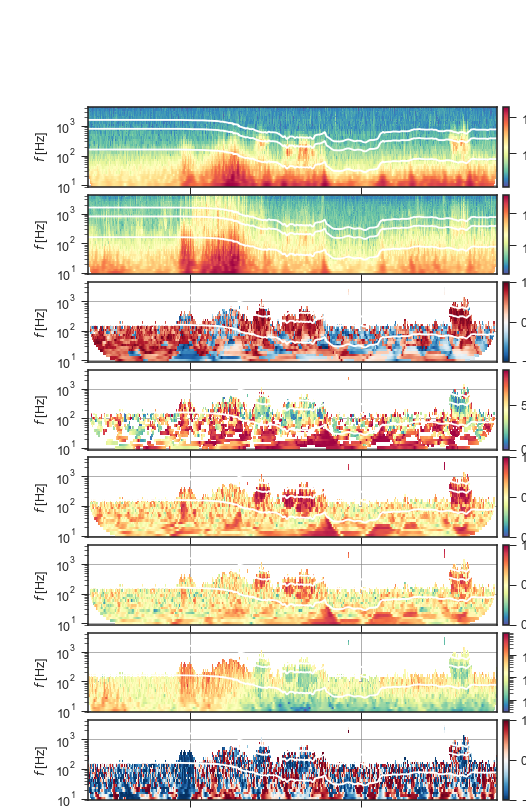

Text(0, 0.5, '$S_{||}/|S|$\n ')

In [9]:
%matplotlib notebook
f, axs = plt.subplots(8, sharex="all", figsize=(6.5, 10))
f.subplots_adjust(left=.15, right=.85, hspace=0.1)

axs[0], caxs0 = plot_spectr(axs[0], b_sum, yscale="log", cscale="log", cmap="Spectral_r")
plot_line(axs[0], f_ce, color="w")
plot_line(axs[0], f_ce_01, color="w")
plot_line(axs[0], f_ce_05, color="w")
axs[0].set_ylabel("$f$ [Hz]")
caxs0.set_ylabel("$B^2$" + "\n" +"[nT$^2$ Hz$^{-1}$]")

axs[1], caxs1 = plot_spectr(axs[1], e_sum, yscale="log", cscale="log", cmap="Spectral_r")
plot_line(axs[1], f_ce, color="w")
plot_line(axs[1], f_ce_01, color="w")
plot_line(axs[1], f_ce_05, color="w")
axs[1].set_ylabel("$f$ [Hz]")
caxs1.set_ylabel("$E^2$" + "\n" + "[mV$^2$ m$^{-2}$ Hz$^{-1}$]")

axs[2], caxs2 = plot_spectr(axs[2], ellipticity, yscale="log", cmap="RdBu_r", clim=[-1, 1])
plot_line(axs[2], f_ce, color="w")
plot_line(axs[2], f_ce_01, color="w")
plot_line(axs[2], f_ce_05, color="w")
axs[2].set_ylabel("$f$ [Hz]")
caxs2.set_ylabel("Ellipticity" + "\n" + " ")

axs[3], caxs3 = plot_spectr(axs[3], thetak * 180 / np.pi, yscale="log", cmap="Spectral_r", clim=[0, 90])
plot_line(axs[3], f_ce, color="w")
plot_line(axs[3], f_ce_01, color="w")
plot_line(axs[3], f_ce_05, color="w")
axs[3].set_ylabel("$f$ [Hz]")
caxs3.set_ylabel("$\\theta_k$" + "\n" + "[$^\\circ$]")

axs[4], caxs4 = plot_spectr(axs[4], dop, yscale="log", cmap="Spectral_r", clim=[0, 1])
plot_line(axs[4], f_ce, color="w")
plot_line(axs[4], f_ce_01, color="w")
plot_line(axs[4], f_ce_05, color="w")
axs[4].set_ylabel("$f$ [Hz]")
caxs4.set_ylabel("DOP" + "\n" + " ")


axs[5], caxs5 = plot_spectr(axs[5], planarity, yscale="log", cmap="Spectral_r", clim=[0, 1])
plot_line(axs[5], f_ce, color="w")
plot_line(axs[5], f_ce_01, color="w")
plot_line(axs[5], f_ce_05, color="w")
axs[5].set_ylabel("$f$ [Hz]")
caxs5.set_ylabel("Planarity" + "\n" + " ")


axs[6], caxs6 = plot_spectr(axs[6], v_ph, yscale="log", cscale="log", cmap="Spectral_r")
plot_line(axs[6], f_ce, color="w")
plot_line(axs[6], f_ce_01, color="w")
plot_line(axs[6], f_ce_05, color="w")
axs[6].set_ylabel("$f$ [Hz]")
caxs6.set_ylabel("E/B" + "\n" + "[m s$^{-1}$]")

axs[7], caxs7 = plot_spectr(axs[7], pflux_z, yscale="log", cmap="RdBu_r", clim=[-1, 1])
plot_line(axs[7], f_ce, color="w")
plot_line(axs[7], f_ce_01, color="w")
plot_line(axs[7], f_ce_05, color="w")
axs[7].set_ylabel("$f$ [Hz]")
caxs7.set_ylabel("$S_{||}/|S|$" + "\n" + " ")